
<td>
<a href="https://colab.research.google.com/github/raoulg/MADS-MachineLearning-course/blob/master/notebooks/4_tuning_networks/05_minimal_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
</td>

In [15]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

This tutorial is based on the PyTorch tutorial for transfer learning. The original tutorial can be found [here](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

Transfer learning utilizes the idea that a model trained on a large dataset can be used as a starting point for a model trained on a smaller dataset. This is especially useful when the smaller dataset is not large enough to train a model from scratch. In this tutorial, we will use a pre-trained model to classify ants and bees. The dataset contains 120 training images and 75 validation images for each class.

The two major transfer learning scenarios look as follows:

-   **Finetuning the ConvNet**: Instead of random initialization, we
    initialize the network with a pretrained network, like the one that
    is trained on imagenet 1000 dataset. Rest of the training looks as
    usual.
-   **ConvNet as fixed feature extractor**: Here, we will freeze the
    weights for all of the network except that of the final fully
    connected layer. This last fully connected layer is replaced with a
    new one with random weights and only this layer is trained.


In [16]:
import os

# Check if the notebook is running on Google Colab
if 'COLAB_GPU' in os.environ:
    # Running on Google Colab; install loguru
    !pip install loguru
else:
    # Not running on Google Colab; you might be on a local setup
    print("Not running on Google Colab. Make sure you have hardware accelaration available.")

from pathlib import Path
import requests
import zipfile
from loguru import logger


Not running on Google Colab. Make sure you have hardware accelaration available.


Let's download a small dataset.

In [17]:
def get_hymenoptera():
    datadir = Path.home() / ".cache/mads_datasets/"
    url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
    if not datadir.exists():
        logger.info(f"Creating directory {datadir}")
        datadir.mkdir(parents=True)

        response = requests.get(url)
        zip_file_path = datadir / "hymenoptera_data.zip"
        with open(zip_file_path, "wb") as f:
            f.write(response.content)

        logger.info(f"Extracting {zip_file_path}")
        with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
            zip_ref.extractall(datadir)
        zip_file_path.unlink()
    else:
        logger.info(f"Directory {datadir} already exists, skipping download.")
    return datadir / "hymenoptera_data"

datadir = get_hymenoptera()

2024-10-07 19:28:12.178 | INFO     | __main__:get_hymenoptera:18 - Directory C:\Users\leons\.cache\mads_datasets already exists, skipping download.


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

Load Data
=========

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we\'re going to solve is training a model to classify
**ants** and **bees**. We have about 120 training images each for ants
and bees.

There are 75 validation images for each class. Usually, this
is too small of a dataset to generalize upon, if trained from scratch.
Since we are using transfer learning, we should be able to generalize
reasonably well.

This dataset is a very small subset of imagenet.

In [19]:
def create_dataloaders():
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    image_datasets = {x: datasets.ImageFolder(datadir / x, data_transforms[x]) for x in ['train', 'val']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                                shuffle=True, num_workers=4)
                for x in ['train', 'val']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes
    return dataloaders, dataset_sizes, class_names

dataloaders, dataset_sizes, class_names = create_dataloaders()

In [20]:
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = "cpu"
    logger.warning("This model will take 15-20 minutes on CPU. Consider using accelaration, eg with google colab (see button on top of the page)")
logger.info(f"Using {device}")

2024-10-07 19:28:12.215 | INFO     | __main__:<module>:8 - Using cuda


Visualize a few images
======================

Let\'s visualize a few training images so as to understand the data
augmentations.


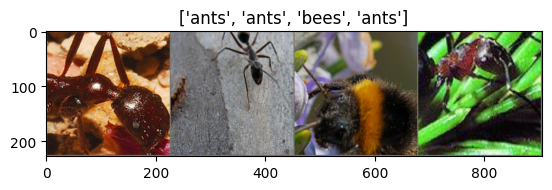

In [21]:
def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
img = torchvision.utils.make_grid(inputs)

imshow(img, title=[class_names[x] for x in classes])

# Training the model

Up to this point, we have been using the mltrainer module.
However, to both make it easer to run this on google colab and to show you the full code of a training loop, I will define the functions for training and evaluating the model here.

In [22]:
def train(model, dataloader, lossfn, optimizer, device):
    model.train()
    train_loss: float = 0.0
    train_acc: float = 0.0
    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        yhat = model(x)
        loss = lossfn(yhat, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, acc = torch.max(yhat, 1)
        train_acc += torch.sum(acc == y.data)
    return train_loss, train_acc

In [23]:
def test(model, dataloader, lossfn, optimizer, scheduler, device):
    model.eval()
    test_loss: float = 0.0
    test_acc: float = 0.0
    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device)
        yhat = model(x)
        loss = lossfn(yhat, y)
        test_loss += loss.item()
        _, acc = torch.max(yhat, 1)
        test_acc += torch.sum(acc == y.data)
    scheduler.step(test_loss)
    return test_loss, test_acc


In [24]:
def train_model(model, lossfn, optimizer, scheduler, num_epochs, dataloaders, dataset_sizes, device):
    with TemporaryDirectory() as tempdir:
        best_model_params_path = Path(tempdir) / 'best_model_params.pt'
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0 # we will only save the best model

        for epoch in range(num_epochs):
            logger.info(f'Epoch {epoch}/{num_epochs - 1}')
            train_loss, train_acc = train(model, dataloaders['train'], lossfn, optimizer, device)
            train_loss = train_loss / dataset_sizes['train']
            train_acc = train_acc / dataset_sizes['train']
            logger.info(f'Train Loss: {train_loss:.4f} Accuracy: {train_acc:.4f}')
            test_loss, test_acc = test(model, dataloaders['val'], lossfn, optimizer, scheduler, device)
            test_loss = test_loss / dataset_sizes['val']
            test_acc = test_acc / dataset_sizes['val']
            logger.info(f'Test Loss: {test_loss:.4f} Accuracy: {test_acc:.4f}')
            if test_acc > best_acc:
                    best_acc = test_acc
                    logger.info(f"New best accuracy: {best_acc:.4f}, saving model")
                    torch.save(model.state_dict(), best_model_params_path)
        model.load_state_dict(torch.load(best_model_params_path))
        return model

Visualizing the model predictions
=================================

Generic function to display predictions for a few images


In [25]:
def visualize_model(model, num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                title = class_names[preds[j]]
                ax.set_title(f'predicted: {title}')
                imshow(inputs.cpu().data[j], title)

                if images_so_far == num_images:
                    return

Finetuning the ConvNet
======================

Load a pretrained model and reset final fully connected layer.


In [26]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)
model.requires_grad_(False)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)
lossfn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs

settings = {'step_size' : 7, 'gamma' : 0.1}
scheduler = lr_scheduler.StepLR(optimizer, **settings)

Using cache found in C:\Users\leons/.cache\torch\hub\pytorch_vision_v0.10.0


In [27]:
model = train_model(model, lossfn, optimizer, scheduler, 25, dataloaders, dataset_sizes, device)

2024-10-07 19:28:16.417 | INFO     | __main__:train_model:8 - Epoch 0/24
2024-10-07 19:28:21.486 | INFO     | __main__:train_model:12 - Train Loss: 0.1463 Accuracy: 0.6639
c:\Users\leons\Desktop\school\MLTrainer\MLTrainer\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
2024-10-07 19:28:26.021 | INFO     | __main__:train_model:16 - Test Loss: 0.0588 Accuracy: 0.9346
2024-10-07 19:28:26.022 | INFO     | __main__:train_model:19 - New best accuracy: 0.9346, saving model
2024-10-07 19:28:26.147 | INFO     | __main_

Train and evaluate
==================

It should take around 15-25 min on CPU. On GPU though, it takes less
than a minute.


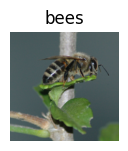

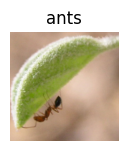

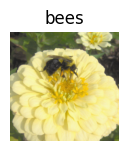

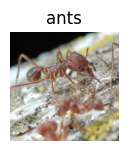

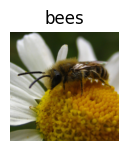

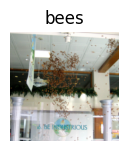

In [28]:
visualize_model(model)

ConvNet as fixed feature extractor
==================================

Here, we need to freeze all the network except the final layer. We need
to set `requires_grad = False` to freeze the parameters so that the
gradients are not computed in `backward()`.

This has some advantages over finetuning the complete model:
- **Faster**: Since we are not computing most of the gradients, the
    forward pass is faster.
- **Memory Efficient**: The memory required for computing the gradients is
    less.
- **Less risk of overfitting**: Since most of the model is frozen, the
    risk of overfitting on this small dataset is less.



In [29]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

lossfn = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Train and evaluate
==================

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don\'t need to be computed for most of the
network. However, forward does need to be computed.


In [30]:
model_conv = train_model(model_conv, lossfn, optimizer, scheduler, 25, dataloaders, dataset_sizes, device)

2024-10-07 19:32:12.337 | INFO     | __main__:train_model:8 - Epoch 0/24
2024-10-07 19:32:16.564 | INFO     | __main__:train_model:12 - Train Loss: 0.1620 Accuracy: 0.6148
2024-10-07 19:32:20.556 | INFO     | __main__:train_model:16 - Test Loss: 0.0578 Accuracy: 0.9477
2024-10-07 19:32:20.557 | INFO     | __main__:train_model:19 - New best accuracy: 0.9477, saving model
2024-10-07 19:32:20.616 | INFO     | __main__:train_model:8 - Epoch 1/24
2024-10-07 19:32:24.662 | INFO     | __main__:train_model:12 - Train Loss: 0.0936 Accuracy: 0.8361
2024-10-07 19:32:28.601 | INFO     | __main__:train_model:16 - Test Loss: 0.0576 Accuracy: 0.9346
2024-10-07 19:32:28.602 | INFO     | __main__:train_model:8 - Epoch 2/24
2024-10-07 19:32:32.661 | INFO     | __main__:train_model:12 - Train Loss: 0.0907 Accuracy: 0.8238
2024-10-07 19:32:36.632 | INFO     | __main__:train_model:16 - Test Loss: 0.0635 Accuracy: 0.9216
2024-10-07 19:32:36.634 | INFO     | __main__:train_model:8 - Epoch 3/24
2024-10-07 19:

KeyboardInterrupt: 

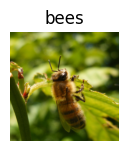

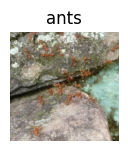

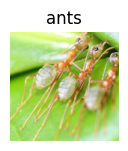

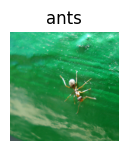

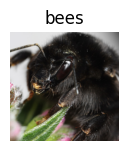

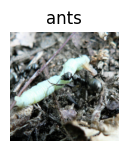

In [22]:
visualize_model(model_conv)